In [18]:
# !pip install python-sat

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from typing import List, Tuple, Set, Dict, Optional
from collections import defaultdict
from pysat.solvers import Glucose3
from pysat.formula import CNF
import heapq
from itertools import product, combinations

# UTILITY FUNCTIONS

In [20]:
class BridgeUtils:
    """Utility functions shared by bridges"""

    @staticmethod
    def bridges_cross(key1, key2):
        """Check if two bridges cross each other"""
        (r1, c1), (r2, c2) = key1
        (r3, c3), (r4, c4) = key2

        # Bridge 1 horizontal, Bridge 2 vertical
        if r1 == r2 and c3 == c4:
            min_c, max_c = min(c1, c2), max(c1, c2)
            min_r, max_r = min(r3, r4), max(r3, r4)
            if min_c < c3 < max_c and min_r < r1 < max_r:
                return True

        # Bridge 1 vertical, Bridge 2 horizontal
        elif c1 == c2 and r3 == r4:
            min_r, max_r = min(r1, r2), max(r1, r2)
            min_c, max_c = min(c3, c4), max(c3, c4)
            if min_r < r3 < max_r and min_c < c1 < max_c:
                return True

        return False

    @staticmethod
    def is_connected(bridges, all_islands):
        """Check if all islands are connected via BFS"""
        if len(all_islands) == 0:
            return True

        # Build adjacency list
        adj = {(r, c): [] for r, c, _ in all_islands}

        for (pos1, pos2), num_bridges in bridges.items():
            if num_bridges > 0:
                adj[pos1].append(pos2)
                adj[pos2].append(pos1)

        # BFS from first island
        start = (all_islands[0][0], all_islands[0][1])
        visited = {start}
        queue = [start]

        while queue:
            current = queue.pop(0)
            for neighbor in adj[current]:
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(neighbor)

        return len(visited) == len(all_islands)

    @staticmethod
    def get_all_bridges_sorted(puzzle, island_requirements=None):
        """Get all possible bridges, sorted by priority"""
        bridges = []
        seen = set()

        for island in puzzle.islands:
            r, c, _ = island
            neighbors = puzzle.get_neighbors(island)

            for (r2, c2), _ in neighbors:
                key = tuple(sorted([(r, c), (r2, c2)]))
                if key not in seen:
                    seen.add(key)
                    bridges.append(key)

        # Sort by priority if requirements provided
        if island_requirements:
            def priority(bridge_key):
                i1, i2 = bridge_key
                req1 = island_requirements.get(i1, 0)
                req2 = island_requirements.get(i2, 0)
                return -(req1 + req2)

            bridges.sort(key=priority)

        return bridges


class VisualizationMixin:
    """Mixin class for solution visualization"""

    def visualize_solution(self, solution=None, title="Solution"):
        """Visualize solution as grid"""
        if solution is None:
            solution = getattr(self, 'solution', None)

        if solution is None:
            print("No solution to visualize!")
            return None

        rows, cols = self.puzzle.rows, self.puzzle.cols
        output = [[' 0 ' for _ in range(cols)] for _ in range(rows)]

        # Place islands
        for r, c, val in self.puzzle.islands:
            output[r][c] = f' {val} '

        # Place bridges
        for (island1, island2), num_bridges in solution.items():
            r1, c1 = island1
            r2, c2 = island2

            if r1 == r2:  # Horizontal
                symbol = ' = ' if num_bridges == 2 else ' - '
                min_c, max_c = min(c1, c2), max(c1, c2)
                for c in range(min_c + 1, max_c):
                    output[r1][c] = symbol
            else:  # Vertical
                symbol = ' $ ' if num_bridges == 2 else ' | '
                min_r, max_r = min(r1, r2), max(r1, r2)
                for r in range(min_r + 1, max_r):
                    output[r][c1] = symbol

        print(f"\n{title}:")
        for row in output:
            print('[' + ','.join([f'"{cell.strip()}"' for cell in row]) + ']')

        return output

# CORE CLASSES

In [21]:
class HashiPuzzle:
    """Class to represent Hashiwokakero puzzle"""

    def __init__(self, grid):
        self.grid = np.array(grid)
        self.rows, self.cols = self.grid.shape
        self.islands = self._find_islands()
        self.bridges = {}

    def _find_islands(self):
        """Find all islands in grid"""
        islands = []
        for i in range(self.rows):
            for j in range(self.cols):
                if self.grid[i][j] > 0:
                    islands.append((i, j, self.grid[i][j]))
        return islands

    def get_neighbors(self, island):
        """Find all islands that can connect to this island"""
        row, col, _ = island
        neighbors = []

        directions = [(-1, 0, 'vertical'), (1, 0, 'vertical'),
                     (0, -1, 'horizontal'), (0, 1, 'horizontal')]

        for dr, dc, dir_type in directions:
            r, c = row + dr, col + dc
            while 0 <= r < self.rows and 0 <= c < self.cols:
                if self.grid[r][c] > 0:
                    neighbors.append(((r, c), dir_type))
                    break
                r += dr
                c += dc

        return neighbors

    @staticmethod
    def read_from_file(filename):
        """Read puzzle from file"""
        with open(filename, 'r') as f:
            lines = f.readlines()

        grid = []
        for line in lines:
            row = [int(x.strip()) for x in line.split(',')]
            grid.append(row)

        return HashiPuzzle(grid)


class BridgeVariable:
    """Class to manage logic variables for bridges"""

    def __init__(self, puzzle: HashiPuzzle):
        self.puzzle = puzzle
        self.var_counter = 1
        self.bridge_to_var = {}
        self.var_to_bridge = {}
        self._initialize_variables()

    def _initialize_variables(self):
        """Create logic variables for all possible bridges"""
        for island1 in self.puzzle.islands:
            neighbors = self.puzzle.get_neighbors(island1)
            r1, c1, _ = island1

            for (r2, c2), _ in neighbors:
                island2 = (r2, c2)
                key = tuple(sorted([(r1, c1), island2]))

                if key not in self.bridge_to_var:
                    for num_bridges in [1, 2]:
                        var = self.var_counter
                        self.bridge_to_var[(key, num_bridges)] = var
                        self.var_to_bridge[var] = (key, num_bridges)
                        self.var_counter += 1

    def get_variable(self, island1_pos, island2_pos, num_bridges):
        """Get logic variable for a bridge"""
        key = tuple(sorted([island1_pos, island2_pos]))
        return self.bridge_to_var.get((key, num_bridges))

# CONSTRAINT PROPAGATION

In [22]:
class ConstraintPropagation:
    """Class containing constraint propagation rules"""

    def __init__(self, puzzle: HashiPuzzle):
        self.puzzle = puzzle
        self.forced_bridges = {}
        self.forbidden_bridges = set()
        self.min_bridges = {}

    def apply_all_rules(self):
        """Apply all rules and return forced bridges"""
        self.forced_bridges = {}
        self.forbidden_bridges = set()
        self.min_bridges = {}

        for island in self.puzzle.islands:
            r, c, value = island
            neighbors = self.puzzle.get_neighbors(island)

            # Rule 1: Island số 8 (ở giữa)
            if value == 8 and len(neighbors) == 4:
                self._force_all_double(island, neighbors)

            # Rule 2: Corner rules
            if self._is_corner(r, c):
                self._apply_corner_rules(island, neighbors)

            # Rule 3: Edge rules
            if self._is_edge(r, c) and not self._is_corner(r, c):
                self._apply_edge_rules(island, neighbors)

            # Rule 4: Single neighbor rule
            if len(neighbors) == 1:
                self._apply_single_neighbor_rule(island, neighbors)

            # Rule 5: Forced connections
            self._check_forced_connections(island, neighbors)

            # Rule 6: Sub-saturation rule
            self._apply_subsaturation_rule(island, neighbors)

        # Rule 7: Isolation Prevention
        self._apply_isolation_prevention()

        return self.forced_bridges, self.forbidden_bridges, self.min_bridges

    def _is_corner(self, r, c):
        rows, cols = self.puzzle.rows, self.puzzle.cols
        return (r == 0 or r == rows - 1) and (c == 0 or c == cols - 1)

    def _is_edge(self, r, c):
        rows, cols = self.puzzle.rows, self.puzzle.cols
        return (r == 0 or r == rows - 1 or c == 0 or c == cols - 1)

    def _force_all_double(self, island, neighbors):
        r, c, _ = island
        for (nr, nc), _ in neighbors:
            bridge_key = tuple(sorted([(r, c), (nr, nc)]))
            self.forced_bridges[bridge_key] = 2

    def _apply_corner_rules(self, island, neighbors):
        r, c, value = island

        if value == 4 and len(neighbors) == 2:
            for (nr, nc), _ in neighbors:
                bridge_key = tuple(sorted([(r, c), (nr, nc)]))
                self.forced_bridges[bridge_key] = 2

        elif value == 3 and len(neighbors) == 2:
            for (nr, nc), _ in neighbors:
                bridge_key = tuple(sorted([(r, c), (nr, nc)]))
                self.min_bridges[bridge_key] = 1

    def _apply_edge_rules(self, island, neighbors):
        r, c, value = island

        if value == 6 and len(neighbors) == 3:
            for (nr, nc), _ in neighbors:
                bridge_key = tuple(sorted([(r, c), (nr, nc)]))
                self.forced_bridges[bridge_key] = 2

    def _apply_single_neighbor_rule(self, island, neighbors):
        r, c, value = island

        if value <= 2 and len(neighbors) == 1:
            (nr, nc), _ = neighbors[0]
            bridge_key = tuple(sorted([(r, c), (nr, nc)]))
            self.forced_bridges[bridge_key] = value

    def _check_forced_connections(self, island, neighbors):
        r, c, value = island
        n = len(neighbors)

        if n == 0:
            return

        max_possible = n * 2

        if value == max_possible:
            for (nr, nc), _ in neighbors:
                bridge_key = tuple(sorted([(r, c), (nr, nc)]))
                self.forced_bridges[bridge_key] = 2

    def _apply_subsaturation_rule(self, island, neighbors):
        r, c, value = island
        n = len(neighbors)

        if n == 0:
            return

        max_possible = 2 * n

        if value == max_possible - 1:
            for (nr, nc), _ in neighbors:
                bridge_key = tuple(sorted([(r, c), (nr, nc)]))
                if bridge_key not in self.forced_bridges:
                    self.min_bridges[bridge_key] = 1

    def _apply_isolation_prevention(self):
        for i, island1 in enumerate(self.puzzle.islands):
            r1, c1, val1 = island1
            neighbors = self.puzzle.get_neighbors(island1)

            for (r2, c2), _ in neighbors:
                val2 = None
                for r, c, v in self.puzzle.islands:
                    if r == r2 and c == c2:
                        val2 = v
                        break

                if val2 is None:
                    continue

                bridge_key = tuple(sorted([(r1, c1), (r2, c2)]))

                if val1 == 1 and val2 == 1:
                    self.forbidden_bridges.add(bridge_key)

    def is_bridge_forbidden(self, bridge_key, num_bridges):
        if bridge_key in self.forbidden_bridges:
            return True

        island1, island2 = bridge_key
        val1 = val2 = None

        for r, c, v in self.puzzle.islands:
            if (r, c) == island1:
                val1 = v
            if (r, c) == island2:
                val2 = v

        if val1 == 2 and val2 == 2 and num_bridges == 2:
            return True

        return False

    def get_min_bridges(self, bridge_key):
        return self.min_bridges.get(bridge_key, 0)

# CNF GENERATOR

In [23]:
class CNFGenerator:
    """Class to generate CNF constraints for Hashiwokakero"""

    def __init__(self, puzzle: HashiPuzzle):
        self.puzzle = puzzle
        self.bridge_vars = BridgeVariable(puzzle)
        self.clauses = []

    def generate_cnf(self):
        """Generate all CNF constraints"""
        self.clauses = []

        self._add_island_count_constraints()
        self._add_bridge_mutex_constraints()
        self._add_no_crossing_constraints()

        # Remove duplicates
        unique_clauses = set()
        for clause in self.clauses:
            unique_clauses.add(tuple(sorted(clause)))
        self.clauses = [list(clause) for clause in unique_clauses]

        return self.clauses

    def _add_island_count_constraints(self):
        for island in self.puzzle.islands:
            r, c, required_count = island
            island_pos = (r, c)

            neighbors = self.puzzle.get_neighbors(island)
            bridge_vars = []

            for (r2, c2), _ in neighbors:
                neighbor_pos = (r2, c2)
                var1 = self.bridge_vars.get_variable(island_pos, neighbor_pos, 1)
                var2 = self.bridge_vars.get_variable(island_pos, neighbor_pos, 2)
                if var1 and var2:
                    bridge_vars.append((var1, var2))

            if len(bridge_vars) == 0:
                continue

            self._add_exactly_k_constraint(bridge_vars, required_count)

    def _add_exactly_k_constraint(self, bridge_vars, k):
        n = len(bridge_vars)
        self._add_at_least_k(bridge_vars, k)
        self._add_at_most_k(bridge_vars, k)

    def _add_at_least_k(self, bridge_vars, k):
        n = len(bridge_vars)
        max_possible = 2 * n

        if k == 0:
            return

        if k > max_possible:
            self.clauses.append([])
            return

        if n <= 4:
            for assignment in product([0, 1, 2], repeat=n):
                total = sum(assignment)
                if total < k:
                    clause = []
                    for i, bridges in enumerate(assignment):
                        v1, v2 = bridge_vars[i]
                        if bridges == 0:
                            clause.extend([v1, v2])
                        elif bridges == 1:
                            clause.extend([-v1, v2])
                        elif bridges == 2:
                            clause.extend([v1, -v2])

                    if clause:
                        self.clauses.append(clause)

    def _add_at_most_k(self, bridge_vars, k):
        n = len(bridge_vars)

        if k >= 2 * n:
            return

        if n <= 4:
            for assignment in product([0, 1, 2], repeat=n):
                total = sum(assignment)
                if total > k:
                    clause = []
                    for i, bridges in enumerate(assignment):
                        v1, v2 = bridge_vars[i]
                        if bridges == 0:
                            clause.extend([v1, v2])
                        elif bridges == 1:
                            clause.extend([-v1, v2])
                        elif bridges == 2:
                            clause.extend([v1, -v2])

                    if clause:
                        self.clauses.append(clause)

    def _add_bridge_mutex_constraints(self):
        for (key, num_bridges), var in self.bridge_vars.bridge_to_var.items():
            if num_bridges == 1:
                var1 = var
                var2 = self.bridge_vars.bridge_to_var.get((key, 2))
                if var2:
                    self.clauses.append([-var1, -var2])

    def _add_no_crossing_constraints(self):
        all_bridge_keys = set()
        for (key, num_bridges) in self.bridge_vars.bridge_to_var.keys():
            all_bridge_keys.add(key)

        all_bridge_keys = list(all_bridge_keys)

        for i in range(len(all_bridge_keys)):
            for j in range(i + 1, len(all_bridge_keys)):
                key1 = all_bridge_keys[i]
                key2 = all_bridge_keys[j]

                if BridgeUtils.bridges_cross(key1, key2):
                    for n1 in [1, 2]:
                        for n2 in [1, 2]:
                            var1 = self.bridge_vars.bridge_to_var.get((key1, n1))
                            var2 = self.bridge_vars.bridge_to_var.get((key2, n2))
                            if var1 and var2:
                                self.clauses.append([-var1, -var2])

# PYSAT SOLVER

In [24]:
class PySATSolver(VisualizationMixin):
    """Solver uses PySAT library with optional Constraint Propagation"""

    def __init__(self, puzzle: HashiPuzzle):
        self.puzzle = puzzle
        self.cnf_gen = CNFGenerator(puzzle)
        self.solution = None
        self.solve_time = 0

    def solve(self):
        """Solve puzzle using PySAT"""
        start_time = time.time()

        # Generate CNF
        clauses = self.cnf_gen.generate_cnf()

        # Create SAT solver
        solver = Glucose3()

        # Add clauses
        for clause in clauses:
            solver.add_clause(clause)

        # Solve with connectivity check
        while solver.solve():
            model = solver.get_model()
            solution = self._decode_solution(model)

            # Check if solution is connected
            if BridgeUtils.is_connected(solution, self.puzzle.islands):
                self.solution = solution
                self.solve_time = time.time() - start_time
                return True, self.solution

            # Block this solution and try again
            blocking_clause = [-lit for lit in model if lit in self.cnf_gen.bridge_vars.var_to_bridge]
            solver.add_clause(blocking_clause)

        # No valid solution found
        self.solve_time = time.time() - start_time
        return False, None

    def _decode_solution(self, model):
        """Decode SAT model to solution"""
        bridges = {}
        for var in model:
            if var > 0 and var in self.cnf_gen.bridge_vars.var_to_bridge:
                bridge_key, num_bridges = self.cnf_gen.bridge_vars.var_to_bridge[var]
                bridges[bridge_key] = num_bridges
        return bridges

    def get_stats(self):
        return {
            'solve_time': self.solve_time,
            'num_variables': self.cnf_gen.bridge_vars.var_counter - 1,
            'num_clauses': len(self.cnf_gen.clauses),
            'num_islands': len(self.puzzle.islands)
        }

# A* SEARCH ALGORITHM

In [25]:
class AStarState:
    """Optimized state for A* search"""

    def __init__(self, bridges, island_counts, g_cost):
        self.bridges = bridges
        self.island_counts = island_counts
        self.g_cost = g_cost
        self._hash = None

    def get_hash(self):
        """Cache hash to avoid recomputation"""
        if self._hash is None:
            self._hash = hash(tuple(sorted(self.bridges.items())))
        return self._hash

    def __eq__(self, other):
        return self.get_hash() == other.get_hash()

    def __hash__(self):
        return self.get_hash()


class AStarSolver(VisualizationMixin):
    """A* Solver with complete rule-based heuristic and optimizations"""

    def __init__(self, puzzle, use_advanced_heuristic=True):
        self.puzzle = puzzle
        self.solution = None
        self.solve_time = 0
        self.nodes_expanded = 0
        self.use_advanced_heuristic = use_advanced_heuristic

        # Precompute island requirements
        self.island_requirements = {
            (r, c): req for r, c, req in puzzle.islands
        }

        # Get all bridges sorted by priority
        self.all_bridges = BridgeUtils.get_all_bridges_sorted(
            puzzle, self.island_requirements
        )

        # Build bridge graph for O(1) neighbor lookup
        self.bridge_graph = self._build_bridge_graph()

        # Precompute crossing map for O(1) crossing check
        self.crossing_map = self._build_crossing_map()

    def _build_bridge_graph(self):
        """Build adjacency list for bridges: O(n) construction, O(1) lookup"""
        graph = defaultdict(list)
        for bridge_key in self.all_bridges:
            pos1, pos2 = bridge_key
            graph[pos1].append(pos2)
            graph[pos2].append(pos1)
        return graph

    def _build_crossing_map(self):
        """Precompute which bridges cross each other: O(n²) construction, O(1) lookup"""
        crossing = defaultdict(set)

        for i, b1 in enumerate(self.all_bridges):
            for b2 in self.all_bridges[i+1:]:
                if BridgeUtils.bridges_cross(b1, b2):
                    crossing[b1].add(b2)
                    crossing[b2].add(b1)

        return crossing

    def solve(self):
        """A* search algorithm"""
        start_time = time.time()

        # Initialize
        initial_counts = {pos: 0 for pos in self.island_requirements}
        initial_state = AStarState({}, initial_counts, 0)

        # Priority queue: (f_score, counter, state)
        open_set = []
        counter = 0
        h_initial = self._heuristic(initial_state)
        heapq.heappush(open_set, (h_initial, counter, initial_state))

        closed_set = set()
        best_f_score = {initial_state.get_hash(): h_initial}

        # A* main loop
        while open_set:
            # Timeout check
            if self.nodes_expanded > 100000:
                break
            if time.time() - start_time > 60:
                break

            f_score, _, current = heapq.heappop(open_set)
            self.nodes_expanded += 1

            # Goal check
            if self._is_goal(current):
                self.solution = current.bridges
                self.solve_time = time.time() - start_time
                return True, self.solution

            # Skip if already visited
            current_hash = current.get_hash()
            if current_hash in closed_set:
                continue
            closed_set.add(current_hash)

            # Generate and process successors
            successors = self._get_successors(current)

            for successor in successors:
                succ_hash = successor.get_hash()

                if succ_hash in closed_set:
                    continue

                # Calculate f-score
                h = self._heuristic(successor)
                f = successor.g_cost + h

                # Add to open set if better path found
                if succ_hash not in best_f_score or f < best_f_score[succ_hash]:
                    best_f_score[succ_hash] = f
                    counter += 1
                    heapq.heappush(open_set, (f, counter, successor))

        self.solve_time = time.time() - start_time
        return False, None

    def _is_goal(self, state):
        """Check if state is a goal state"""
        # Check all islands satisfied
        for pos, req in self.island_requirements.items():
            if state.island_counts[pos] != req:
                return False

        # Check connectivity using BridgeUtils
        return BridgeUtils.is_connected(state.bridges, self.puzzle.islands)

    def _heuristic(self, state):
        """
        Complete 5-component heuristic:
        1. Basic deficit (admissible baseline)
        2. Forced bridges estimation
        3. Isolation detection
        4. Sub-saturation check
        5. Dead-end detection
        """
        if not self.use_advanced_heuristic:
            return self._simple_heuristic(state)

        h = 0.0

        # Component 1: Basic deficit (admissible)
        total_deficit = 0
        island_deficits = {}

        for pos, req in self.island_requirements.items():
            current = state.island_counts[pos]
            deficit = req - current

            if deficit > 0:
                total_deficit += deficit
                island_deficits[pos] = deficit

        h = total_deficit / 2.0  # Each bridge satisfies 2 islands

        # Component 2: Forced bridges estimation
        forced_bonus = self._estimate_forced_bridges(state, island_deficits)
        h += forced_bonus * 0.5  # Scaled to maintain admissibility

        # Component 3: Isolation detection
        isolation_penalty = self._detect_potential_isolation(state)
        h += isolation_penalty

        # Component 4: Sub-saturation check
        subsaturation_penalty = self._check_subsaturation(state, island_deficits)
        h += subsaturation_penalty

        # Component 5: Dead-end detection
        if self._has_dead_end(state, island_deficits):
            h += 100  # Large penalty for impossible states

        return h

    def _simple_heuristic(self, state):
        """Simple admissible heuristic: deficit / 2"""
        total_deficit = 0
        for pos, req in self.island_requirements.items():
            deficit = req - state.island_counts[pos]
            if deficit > 0:
                total_deficit += deficit
        return total_deficit / 2.0

    def _estimate_forced_bridges(self, state, island_deficits):
        """Estimate penalty for forced bridges not yet added"""
        penalty = 0.0

        for pos, deficit in island_deficits.items():
            if deficit <= 0:
                continue

            # Use precomputed bridge_graph for O(1) neighbor lookup
            available_neighbors = []
            for neighbor in self.bridge_graph[pos]:
                bridge_key = tuple(sorted([pos, neighbor]))

                # Skip if bridge already used
                if bridge_key in state.bridges:
                    continue

                # Check if neighbor has capacity
                other_capacity = (self.island_requirements[neighbor] -
                                state.island_counts[neighbor])

                if other_capacity > 0:
                    available_neighbors.append((bridge_key, neighbor, other_capacity))

            n_available = len(available_neighbors)

            # Dead end - no available neighbors
            if n_available == 0:
                penalty += 1000
                continue

            max_possible = n_available * 2

            # All neighbors must have 2 bridges
            if deficit == max_possible:
                penalty += n_available * 0.5

            # Single neighbor with small deficit
            elif n_available == 1 and deficit <= 2:
                penalty += 0.5

            # Sub-saturation: V = 2N-1
            elif deficit == max_possible - 1:
                penalty += n_available * 0.3

        return penalty

    def _detect_potential_isolation(self, state):
        """Detect isolated pairs (1-1 or 2-2) that cannot connect to rest"""
        penalty = 0.0

        for bridge_key, num_bridges in state.bridges.items():
            island1, island2 = bridge_key
            val1 = self.island_requirements[island1]
            val2 = self.island_requirements[island2]
            count1 = state.island_counts[island1]
            count2 = state.island_counts[island2]

            # 1-1 fully connected = isolated
            if val1 == 1 and val2 == 1:
                if count1 == 1 and count2 == 1:
                    penalty += 10.0

            # 2=2 fully connected = isolated
            if val1 == 2 and val2 == 2 and num_bridges == 2:
                if count1 == 2 and count2 == 2:
                    penalty += 10.0

        return penalty

    def _check_subsaturation(self, state, island_deficits):
        """Check sub-saturation rule: V = 2N-1 requires all N directions"""
        penalty = 0.0

        for pos, deficit in island_deficits.items():
            if deficit <= 0:
                continue

            # Count connected and available directions using bridge_graph
            connected = 0
            available = 0

            for neighbor in self.bridge_graph[pos]:
                bridge_key = tuple(sorted([pos, neighbor]))

                if bridge_key in state.bridges:
                    connected += 1
                else:
                    # Check if direction is available
                    other_capacity = (self.island_requirements[neighbor] -
                                    state.island_counts[neighbor])
                    if other_capacity > 0:
                        available += 1

            total_directions = connected + available

            # Sub-saturation: if V = 2N-1, all N directions need at least 1 bridge
            if deficit == 2 * total_directions - 1:
                penalty += available * 0.4

        return penalty

    def _has_dead_end(self, state, island_deficits):
        """Check if any island cannot satisfy its requirement"""
        for pos, deficit in island_deficits.items():
            if deficit <= 0:
                continue

            available_capacity = 0

            # Check all neighbors using bridge_graph
            for neighbor in self.bridge_graph[pos]:
                bridge_key = tuple(sorted([pos, neighbor]))

                # Calculate remaining slots
                current_bridges = state.bridges.get(bridge_key, 0)
                remaining_slots = 2 - current_bridges

                if remaining_slots > 0:
                    # Check crossing using precomputed map (O(1))
                    crosses = any(bridge_key in self.crossing_map[existing]
                                for existing in state.bridges)

                    if not crosses:
                        # Calculate available capacity
                        other_deficit = (self.island_requirements[neighbor] -
                                       state.island_counts[neighbor])
                        available = min(remaining_slots, other_deficit)
                        available_capacity += available

            # If available capacity < deficit, impossible to satisfy
            if available_capacity < deficit:
                return True

        return False

    def _get_successors(self, state):
        """Generate successor states using MRV (Most Constrained Variable) heuristic"""
        successors = []

        # Find most constrained island (smallest remaining requirement)
        best_island = None
        min_remaining = float('inf')

        for pos, req in self.island_requirements.items():
            current = state.island_counts[pos]
            remaining = req - current

            if remaining > 0 and remaining < min_remaining:
                min_remaining = remaining
                best_island = pos

        if best_island is None:
            return successors

        # Try adding bridges from this island using bridge_graph
        for neighbor in self.bridge_graph[best_island]:
            bridge_key = tuple(sorted([best_island, neighbor]))

            # Skip if bridge already used
            if bridge_key in state.bridges:
                continue

            # Check capacities
            cap1 = self.island_requirements[best_island] - state.island_counts[best_island]
            cap2 = self.island_requirements[neighbor] - state.island_counts[neighbor]

            if cap1 <= 0 or cap2 <= 0:
                continue

            max_bridges = min(cap1, cap2, 2)

            # Try 1 or 2 bridges
            for num_bridges in range(1, max_bridges + 1):
                # Check crossing using precomputed map
                if self._can_add_bridge(state, bridge_key):
                    # Create successor state
                    new_bridges = state.bridges.copy()
                    new_bridges[bridge_key] = num_bridges

                    new_counts = state.island_counts.copy()
                    new_counts[best_island] += num_bridges
                    new_counts[neighbor] += num_bridges

                    new_g_cost = state.g_cost + num_bridges

                    successor = AStarState(new_bridges, new_counts, new_g_cost)
                    successors.append(successor)

        return successors

    def _can_add_bridge(self, state, new_bridge_key):
        """Check if bridge can be added without crossing (O(1) using crossing_map)"""
        for existing_key in state.bridges:
            if new_bridge_key in self.crossing_map[existing_key]:
                return False
        return True

    def get_stats(self):
        """Get solving statistics"""
        return {
            'solve_time': self.solve_time,
            'nodes_expanded': self.nodes_expanded,
            'num_islands': len(self.puzzle.islands),
            'heuristic_type': 'Advanced (5-component)' if self.use_advanced_heuristic else 'Simple (deficit/2)'
        }

# BACKTRACKING SOLVER

## Naive Backtracking

In [26]:
class NaiveBacktrackingSolver(VisualizationMixin):
    """
    Naive Backtracking Solver - Pure backtracking without CSP optimizations

    Characteristics:
    - Simple depth-first search with backtracking
    - Fixed variable ordering (by bridge list order)
    - Fixed value ordering (0, 1, 2)
    - No forward checking
    - No constraint propagation
    - Check constraints only after full assignment

    Purpose: Baseline for comparison
    """

    def __init__(self, puzzle):
        self.puzzle = puzzle
        self.solution = None
        self.solve_time = 0
        self.nodes_expanded = 0

        # Basic structures
        self.island_requirements = {
            (r, c): req for r, c, req in puzzle.islands
        }
        self.all_bridges = BridgeUtils.get_all_bridges_sorted(puzzle)

    def solve(self):
        """Naive backtracking solve"""
        start_time = time.time()
        self.start_time = start_time
        assignment = {}
        success = self._backtrack_naive(assignment, 0)

        self.solve_time = time.time() - start_time

        if success:
            self.solution = {k: v for k, v in assignment.items() if v > 0}
            return True, self.solution
        else:
            return False, None

    def _backtrack_naive(self, assignment, bridge_index):
        """Pure backtracking - no optimizations"""
        self.nodes_expanded += 1

        # Timeout
        if self.nodes_expanded > 200000:
            return False
        if time.time() - self.start_time > 60:
            return False

        # Base case: all bridges assigned
        if bridge_index >= len(self.all_bridges):
            return self._is_complete_valid_solution(assignment)

        bridge = self.all_bridges[bridge_index]

        # Try all values: 0, 1, 2 (no intelligent ordering)
        for num_bridges in [0, 1, 2]:
            assignment[bridge] = num_bridges

            # Basic check: not exceeding island capacity
            if self._is_consistent(assignment):
                if self._backtrack_naive(assignment, bridge_index + 1):
                    return True

            # Backtrack
            del assignment[bridge]

        return False

    def _is_consistent(self, assignment):
        """Basic consistency check: no island exceeds requirement"""
        island_counts = defaultdict(int)

        for bridge_key, num_bridges in assignment.items():
            island1, island2 = bridge_key
            island_counts[island1] += num_bridges
            island_counts[island2] += num_bridges

        # Check no island exceeds requirement
        for island_pos, count in island_counts.items():
            if count > self.island_requirements.get(island_pos, 0):
                return False

        # Check no crossing
        bridges_used = [(k, v) for k, v in assignment.items() if v > 0]
        for i, (key1, val1) in enumerate(bridges_used):
            for key2, val2 in bridges_used[i+1:]:
                if BridgeUtils.bridges_cross(key1, key2):
                    return False

        return True

    def _is_complete_valid_solution(self, assignment):
        """Check if assignment is complete and valid"""
        island_counts = defaultdict(int)

        for bridge_key, num_bridges in assignment.items():
            island1, island2 = bridge_key
            island_counts[island1] += num_bridges
            island_counts[island2] += num_bridges

        # Check all islands satisfied
        for island_pos, required in self.island_requirements.items():
            if island_counts[island_pos] != required:
                return False

        # Check connectivity using BridgeUtils
        return BridgeUtils.is_connected(assignment, self.puzzle.islands)

    def get_stats(self):
        return {
            'solve_time': self.solve_time,
            'nodes_expanded': self.nodes_expanded,
            'algorithm': 'Naive Backtracking'
        }

## Optimized Backtracking

In [27]:
class OptimizedBacktrackingSolver(VisualizationMixin):
    """
    Optimized Backtracking with CSP Techniques + Constraint Propagation

    Enhancements over Naive:
    1. Constraint Propagation preprocessing (7 rules)
    2. MRV (Minimum Remaining Values) heuristic
    3. Forward Checking with propagation
    4. Arc Consistency (AC-3)
    5. Degree Heuristic for tie-breaking
    6. LCV (Least Constraining Value) ordering
    7. Precomputed structures (crossing cache, neighbor map)
    """

    def __init__(self, puzzle):
        self.puzzle = puzzle
        self.solution = None
        self.solve_time = 0
        self.nodes_expanded = 0

        # Basic structures
        self.island_requirements = {
            (r, c): req for r, c, req in puzzle.islands
        }

        # All bridges (sorted by degree heuristic)
        self.all_bridges = BridgeUtils.get_all_bridges_sorted(
            puzzle, self.island_requirements
        )

        # Precomputed structures
        self.island_neighbors = self._precompute_neighbors()
        self.crossing_cache = self._precompute_crossings()

        # Constraint Propagation
        self.propagation = ConstraintPropagation(puzzle)
        self.forced_bridges = {}
        self.forbidden_bridges = set()
        self.min_bridges = {}

    def _precompute_neighbors(self):
        """Precompute neighbor relationships"""
        neighbors = defaultdict(list)
        for bridge_key in self.all_bridges:
            i1, i2 = bridge_key
            neighbors[i1].append(bridge_key)
            neighbors[i2].append(bridge_key)
        return dict(neighbors)

    def _precompute_crossings(self):
        """Precompute crossing relationships"""
        crossings = defaultdict(set)

        for i, bridge1 in enumerate(self.all_bridges):
            for bridge2 in self.all_bridges[i+1:]:
                if BridgeUtils.bridges_cross(bridge1, bridge2):
                    crossings[bridge1].add(bridge2)
                    crossings[bridge2].add(bridge1)

        return dict(crossings)

    def solve(self):
        """Optimized solve with preprocessing"""
        start_time = time.time()
        self.start_time = start_time

        # Step 1: Apply Constraint Propagation (7 rules)
        forced, forbidden, min_bridges = self.propagation.apply_all_rules()
        self.forced_bridges = forced
        self.forbidden_bridges = forbidden
        self.min_bridges = min_bridges

        print(f"  Constraint Propagation Results:")
        print(f"    - Forced bridges: {len(self.forced_bridges)}")
        print(f"    - Forbidden bridges: {len(self.forbidden_bridges)}")
        print(f"    - Minimum constraints: {len(self.min_bridges)}")

        # Step 2: Initialize domains with constraint propagation results
        domains = self._initialize_domains_with_propagation()

        if domains is None:
            self.solve_time = time.time() - start_time
            return False, None

        # Step 3: Initialize island counts
        island_counts = defaultdict(int)

        # Step 4: Start with forced assignments
        assignment = self.forced_bridges.copy()

        # Update counts from forced bridges
        for bridge_key, num_bridges in self.forced_bridges.items():
            i1, i2 = bridge_key
            island_counts[i1] += num_bridges
            island_counts[i2] += num_bridges

        # Step 5: Apply AC-3 for initial consistency
        domains = self._ac3(domains, assignment, island_counts)

        if domains is None:
            self.solve_time = time.time() - start_time
            return False, None

        # Step 6: Backtracking on remaining variables
        success = self._backtrack_optimized(assignment, domains, island_counts)

        self.solve_time = time.time() - start_time

        if success:
            self.solution = {k: v for k, v in assignment.items() if v > 0}
            return True, self.solution
        else:
            return False, None

    def _initialize_domains_with_propagation(self):
        """Initialize domains using constraint propagation results"""
        domains = {}

        for bridge in self.all_bridges:
            # Skip forced bridges
            if bridge in self.forced_bridges:
                continue

            # Skip forbidden bridges
            if bridge in self.forbidden_bridges:
                continue

            # Check minimum requirement
            min_required = self.min_bridges.get(bridge, 0)

            # Check 2-2 isolation
            i1, i2 = bridge
            val1 = self.island_requirements.get(i1, 0)
            val2 = self.island_requirements.get(i2, 0)

            if val1 == 2 and val2 == 2:
                # Cannot have 2 bridges
                domains[bridge] = [0, 1] if min_required == 0 else [1]
            else:
                # Normal domain
                if min_required == 0:
                    domains[bridge] = [0, 1, 2]
                elif min_required == 1:
                    domains[bridge] = [1, 2]
                else:
                    domains[bridge] = [2]

        return domains

    def _ac3(self, domains, assignment, island_counts):
        """AC-3 algorithm for arc consistency"""
        queue = list(domains.keys())

        while queue:
            bridge = queue.pop(0)

            if bridge not in domains or not domains[bridge]:
                continue

            island1, island2 = bridge

            # Revise for both islands
            if self._revise(bridge, island1, domains, assignment, island_counts):
                if not domains[bridge]:
                    return None

                # Add neighbors to queue
                for neighbor_bridge in self.island_neighbors.get(island1, []):
                    if neighbor_bridge != bridge and neighbor_bridge in domains:
                        if neighbor_bridge not in queue:
                            queue.append(neighbor_bridge)

            if self._revise(bridge, island2, domains, assignment, island_counts):
                if not domains[bridge]:
                    return None

                for neighbor_bridge in self.island_neighbors.get(island2, []):
                    if neighbor_bridge != bridge and neighbor_bridge in domains:
                        if neighbor_bridge not in queue:
                            queue.append(neighbor_bridge)

        return domains

    def _revise(self, bridge, island, domains, assignment, island_counts):
        """Revise domain based on island constraints"""
        revised = False
        original_domain = domains[bridge].copy()

        required = self.island_requirements[island]
        current = island_counts[island]

        # Max possible from other unassigned bridges
        max_from_others = 0
        for other_bridge in self.island_neighbors.get(island, []):
            if other_bridge == bridge or other_bridge in assignment:
                continue
            if other_bridge in domains:
                max_from_others += max(domains[other_bridge])

        # Filter domain
        new_domain = []
        for value in domains[bridge]:
            # Check if can satisfy island
            if current + value + max_from_others >= required:
                # Check upper bound
                if current + value <= required:
                    new_domain.append(value)

        if len(new_domain) < len(original_domain):
            domains[bridge] = new_domain
            revised = True

        return revised

    def _backtrack_optimized(self, assignment, domains, island_counts):
        """Optimized backtracking with all techniques"""
        self.nodes_expanded += 1

        # Time out
        if self.nodes_expanded > 100000:
            return False
        if time.time() - self.start_time > 60:
            return False

        # Goal check
        if self._is_goal(assignment, island_counts):
            return True

        # MRV + Degree heuristic
        bridge = self._select_variable_mrv(domains, assignment, island_counts)

        if bridge is None:
            return False

        # LCV ordering
        ordered_values = self._order_values_lcv(
            bridge, domains, assignment, island_counts
        )

        for value in ordered_values:
            # Forward checking
            new_domains, new_counts = self._forward_check(
                bridge, value, domains, assignment, island_counts
            )

            if new_domains is None:
                continue

            # Assign
            assignment[bridge] = value

            # Recurse
            if self._backtrack_optimized(assignment, new_domains, new_counts):
                return True

            # Backtrack
            del assignment[bridge]

        return False

    def _select_variable_mrv(self, domains, assignment, island_counts):
        """MRV + Degree heuristic"""
        best_bridge = None
        min_domain = float('inf')
        max_degree = -1

        for bridge, domain in domains.items():
            if bridge in assignment or not domain:
                continue

            i1, i2 = bridge
            r1 = self.island_requirements[i1] - island_counts[i1]
            r2 = self.island_requirements[i2] - island_counts[i2]

            if r1 <= 0 and r2 <= 0:
                continue

            domain_size = len(domain)
            degree = len([b for b in self.island_neighbors.get(i1, [])
                         if b not in assignment])
            degree += len([b for b in self.island_neighbors.get(i2, [])
                          if b not in assignment])

            if (domain_size < min_domain or
                (domain_size == min_domain and degree > max_degree)):
                min_domain = domain_size
                max_degree = degree
                best_bridge = bridge

        return best_bridge

    def _order_values_lcv(self, bridge, domains, assignment, island_counts):
        """LCV ordering"""
        if bridge not in domains:
            return []

        value_constraints = []

        for value in domains[bridge]:
            constraints = 0

            # Crossing constraints
            if value > 0:
                for cross_bridge in self.crossing_cache.get(bridge, set()):
                    if cross_bridge in domains and cross_bridge not in assignment:
                        constraints += len([v for v in domains[cross_bridge] if v > 0])

            # Neighbor constraints
            i1, i2 = bridge
            for i in [i1, i2]:
                remaining = self.island_requirements[i] - island_counts[i] - value
                for nb in self.island_neighbors.get(i, []):
                    if nb != bridge and nb not in assignment and nb in domains:
                        if remaining < max(domains[nb]):
                            constraints += 1

            value_constraints.append((value, constraints))

        value_constraints.sort(key=lambda x: x[1])
        return [v for v, _ in value_constraints]

    def _forward_check(self, bridge, value, domains, assignment, island_counts):
        """Forward checking with propagation"""
        new_domains = {k: v.copy() for k, v in domains.items()}
        new_counts = island_counts.copy()

        i1, i2 = bridge
        new_counts[i1] += value
        new_counts[i2] += value

        # Check capacity
        if (new_counts[i1] > self.island_requirements[i1] or
            new_counts[i2] > self.island_requirements[i2]):
            return None, None

        # Remove from domains
        if bridge in new_domains:
            del new_domains[bridge]

        # Crossing constraints
        if value > 0:
            for cross_bridge in self.crossing_cache.get(bridge, set()):
                if cross_bridge in new_domains:
                    new_domains[cross_bridge] = [0]

        # Update neighbor domains
        for island_pos in [i1, i2]:
            remaining = self.island_requirements[island_pos] - new_counts[island_pos]

            if remaining < 0:
                return None, None

            for nb in self.island_neighbors.get(island_pos, []):
                if nb == bridge or nb not in new_domains:
                    continue

                new_domain = [v for v in new_domains[nb] if v <= remaining]

                if not new_domain:
                    return None, None

                new_domains[nb] = new_domain

        # AC-3
        new_assignment = assignment.copy()
        new_assignment[bridge] = value
        new_domains = self._ac3(new_domains, new_assignment, new_counts)

        if new_domains is None:
            return None, None

        return new_domains, new_counts

    def _is_goal(self, assignment, island_counts):
        """Goal check"""
        for pos, req in self.island_requirements.items():
            if island_counts[pos] != req:
                return False
        return BridgeUtils.is_connected(assignment, self.puzzle.islands)

    def get_stats(self):
        return {
            'solve_time': self.solve_time,
            'nodes_expanded': self.nodes_expanded,
            'algorithm': 'Optimized Backtracking (CSP + Propagation)',
            'forced_bridges': len(self.forced_bridges),
            'forbidden_bridges': len(self.forbidden_bridges)
        }

# BRUTE FORCE SOLVER

In [28]:
class BruteForceSolver(VisualizationMixin):
    """Brute force solver"""

    def __init__(self, puzzle: HashiPuzzle):
        self.puzzle = puzzle
        self.solution = None
        self.solve_time = 0
        self.combinations_tried = 0
        self.island_requirements = {
            (r, c): req for r, c, req in puzzle.islands
        }

    def solve(self):
        start_time = time.time()

        all_bridges = BridgeUtils.get_all_bridges_sorted(self.puzzle)
        n = len(all_bridges)
        max_combinations = min(3 ** n, 100000)

        if n > 10:
            print(f"  Warning: {n} bridges = {3**n} combinations, limiting to {max_combinations}")

        for combination in product([0, 1, 2], repeat=n):
            self.combinations_tried += 1

            if self.combinations_tried > max_combinations:
                break

            bridges = {all_bridges[i]: num
                      for i, num in enumerate(combination) if num > 0}

            if self._is_valid_solution(bridges):
                self.solution = bridges
                self.solve_time = time.time() - start_time
                return True, bridges

        self.solve_time = time.time() - start_time
        return False, None

    def _is_valid_solution(self, bridges):
        for island_pos, required in self.island_requirements.items():
            current = sum(num for key, num in bridges.items()
                         if island_pos in key)
            if current != required:
                return False

        bridge_list = list(bridges.keys())
        for i in range(len(bridge_list)):
            for j in range(i + 1, len(bridge_list)):
                if BridgeUtils.bridges_cross(bridge_list[i], bridge_list[j]):
                    return False

        return BridgeUtils.is_connected(bridges, self.puzzle.islands)

    def get_stats(self):
        return {
            'solve_time': self.solve_time,
            'combinations_tried': self.combinations_tried
        }

# EXPERIMENT SETUP & EXECUTION

In [29]:
class ExperimentRunner:
    """Run experiments across multiple solvers and test cases"""

    def __init__(self, input_files):
        self.input_files = input_files
        self.results = []

    def run_all_experiments(self):
        """Run all solvers on all test cases"""

        solvers_config = [
            ('PySAT', lambda p: PySATSolver(p)),
            ('A* (Simple)', lambda p: AStarSolver(p, use_advanced_heuristic=False)),
            ('A* (Advanced)', lambda p: AStarSolver(p, use_advanced_heuristic=True)),
            ('Naive Backtracking', lambda p: NaiveBacktrackingSolver(p)),
            ('Optimized Backtracking', lambda p: OptimizedBacktrackingSolver(p)),
            ('Brute Force', lambda p: BruteForceSolver(p))
        ]

        for input_file in self.input_files:
            print(f"\n{'='*80}")
            print(f"Processing: {input_file}")
            print(f"{'='*80}")

            try:
                puzzle = HashiPuzzle.read_from_file(input_file)
                grid_size = f"{puzzle.rows}x{puzzle.cols}"
                num_islands = len(puzzle.islands)

                print(f"Grid: {grid_size}, Islands: {num_islands}")

                for solver_name, solver_factory in solvers_config:
                    print(f"\n  Testing {solver_name}...")

                    try:
                        solver = solver_factory(puzzle)
                        success, solution = solver.solve()
                        stats = solver.get_stats()

                        result = {
                            'input_file': input_file,
                            'grid_size': grid_size,
                            'num_islands': num_islands,
                            'solver': solver_name,
                            'success': success,
                            'solve_time': stats.get('solve_time', 0),
                            'nodes_expanded': stats.get('nodes_expanded',
                                                       stats.get('combinations_tried', 0)),
                            'num_variables': stats.get('num_variables', 0),
                            'num_clauses': stats.get('num_clauses', 0)
                        }

                        self.results.append(result)

                        status = "✓ Solved" if success else "✗ Failed"
                        time_str = f"{stats.get('solve_time', 0):.4f}s"
                        print(f"    {status} in {time_str}")

                        if 'nodes_expanded' in stats:
                            print(f"    Nodes expanded: {stats['nodes_expanded']:,}")
                        if 'combinations_tried' in stats:
                            print(f"    Combinations tried: {stats['combinations_tried']:,}")

                    except Exception as e:
                        print(f"    ✗ Error: {str(e)}")
                        self.results.append({
                            'input_file': input_file,
                            'grid_size': grid_size,
                            'num_islands': num_islands,
                            'solver': solver_name,
                            'success': False,
                            'solve_time': 0,
                            'nodes_expanded': 0,
                            'num_variables': 0,
                            'num_clauses': 0
                        })

            except Exception as e:
                print(f"  ✗ Failed to load puzzle: {str(e)}")

        return pd.DataFrame(self.results)

    def run_pysat_only(self, input_files):
        """Run PySAT only on extra large puzzles"""
        results = []

        for input_file in input_files:
            print(f"\n{'='*80}")
            print(f"Processing: {input_file}")
            print(f"{'='*80}")

            try:
                puzzle = HashiPuzzle.read_from_file(input_file)
                grid_size = f"{puzzle.rows}x{puzzle.cols}"
                num_islands = len(puzzle.islands)

                print(f"Grid: {grid_size}, Islands: {num_islands}")
                print(f"\n  Testing PySAT (only viable solver for this size)...")

                try:
                    solver = PySATSolver(puzzle)
                    success, solution = solver.solve()
                    stats = solver.get_stats()

                    result = {
                        'input_file': input_file,
                        'grid_size': grid_size,
                        'num_islands': num_islands,
                        'solver': 'PySAT',
                        'success': success,
                        'solve_time': stats.get('solve_time', 0),
                        'nodes_expanded': 0,
                        'num_variables': stats.get('num_variables', 0),
                        'num_clauses': stats.get('num_clauses', 0)
                    }

                    results.append(result)

                    status = "✓ Solved" if success else "✗ Failed"
                    time_str = f"{stats.get('solve_time', 0):.4f}s"
                    print(f"    {status} in {time_str}")
                    print(f"    Variables: {stats.get('num_variables', 0):,}")
                    print(f"    Clauses: {stats.get('num_clauses', 0):,}")

                except Exception as e:
                    print(f"    ✗ Error: {str(e)}")
                    results.append({
                        'input_file': input_file,
                        'grid_size': grid_size,
                        'num_islands': num_islands,
                        'solver': 'PySAT',
                        'success': False,
                        'solve_time': 0,
                        'nodes_expanded': 0,
                        'num_variables': 0,
                        'num_clauses': 0
                    })

            except Exception as e:
                print(f"  ✗ Failed to load puzzle: {str(e)}")

        return pd.DataFrame(results)

In [30]:
class ResultsAnalyzer:
    """Analyze and visualize experiment results"""

    def __init__(self, df):
        self.df = df

    def print_summary_table(self):
        """Print summary statistics table"""
        print("\n" + "="*100)
        print("SUMMARY RESULTS")
        print("="*100)

        # Define proper column order
        grid_sizes_ordered = [
            '4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', '11x11',
            '12x12', '13x13', '14x14', '15x15', '16x16', '17x17', '18x18',
            '19x19', '20x20', '21x21', '22x22', '23x23', '24x24', '25x25',
            '30x30', '35x35', '40x40'
        ]

        summary = self.df.pivot_table(
            index='solver',
            columns='grid_size',
            values='solve_time',
            aggfunc='mean'
        )

        # Reorder columns
        existing_cols = [col for col in grid_sizes_ordered if col in summary.columns]
        summary = summary[existing_cols]

        print("\nAverage Solve Time (seconds):")
        print(summary.to_string())

        success_rate = self.df.pivot_table(
            index='solver',
            columns='grid_size',
            values='success',
            aggfunc='mean'
        ) * 100

        # Reorder columns
        existing_cols = [col for col in grid_sizes_ordered if col in success_rate.columns]
        success_rate = success_rate[existing_cols]

        nodes = self.df[self.df['nodes_expanded'] > 0].pivot_table(
            index='solver',
            columns='grid_size',
            values='nodes_expanded',
            aggfunc='mean'
        )

        # Reorder columns
        if len(nodes) > 0:
            existing_cols = [col for col in grid_sizes_ordered if col in nodes.columns]
            nodes = nodes[existing_cols]

        print("\n\nAverage Nodes Expanded:")
        print(nodes.to_string())

    def create_comparison_plots(self):
        """Create comprehensive comparison visualizations"""

        # Plot 1: Solve Time vs Grid Size
        plt.figure(figsize=(10, 6))
        ax1 = plt.gca()
        successful = self.df[self.df['success'] == True]

        for solver in successful['solver'].unique():
            solver_data = successful[successful['solver'] == solver]
            ax1.plot(solver_data['num_islands'], solver_data['solve_time'],
                    marker='o', label=solver, linewidth=2)

        ax1.set_xlabel('Number of Islands', fontsize=12)
        ax1.set_ylabel('Solve Time (seconds)', fontsize=12)
        ax1.set_title('Solve Time vs Problem Size', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')
        plt.tight_layout()
        plt.show()

        # Plot 2: Nodes Expanded vs Grid Size
        plt.figure(figsize=(10, 6))
        ax2 = plt.gca()
        nodes_data = successful[successful['nodes_expanded'] > 0]

        for solver in nodes_data['solver'].unique():
            solver_data = nodes_data[nodes_data['solver'] == solver]
            ax2.plot(solver_data['num_islands'], solver_data['nodes_expanded'],
                    marker='s', label=solver, linewidth=2)

        ax2.set_xlabel('Number of Islands', fontsize=12)
        ax2.set_ylabel('Nodes Expanded', fontsize=12)
        ax2.set_title('Search Space Explored', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')
        plt.tight_layout()
        plt.show()

        # Plot 3: Success Rate
        plt.figure(figsize=(10, 6))
        ax3 = plt.gca()
        success_by_solver = self.df.groupby('solver')['success'].mean() * 100
        colors = plt.cm.Set3(range(len(success_by_solver)))
        bars = ax3.bar(range(len(success_by_solver)), success_by_solver.values, color=colors)
        ax3.set_xticks(range(len(success_by_solver)))
        ax3.set_xticklabels(success_by_solver.index, rotation=45, ha='right')
        ax3.set_ylabel('Success Rate (%)', fontsize=12)
        ax3.set_title('Overall Success Rate by Solver', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')

        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
        plt.tight_layout()
        plt.show()

        # Plot 4: Time Comparison Heatmap
        plt.figure(figsize=(12, 8))
        ax4 = plt.gca()

        # Define proper column order
        grid_sizes_ordered = [
            '4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', '11x11',
            '12x12', '13x13', '14x14', '15x15', '16x16', '17x17', '18x18',
            '19x19', '20x20', '21x21', '22x22', '23x23', '24x24', '25x25'
        ]

        time_pivot = successful.pivot_table(
            index='solver',
            columns='grid_size',
            values='solve_time',
            aggfunc='mean'
        )

        # Reorder columns to proper sequence
        existing_cols = [col for col in grid_sizes_ordered if col in time_pivot.columns]
        time_pivot = time_pivot[existing_cols]

        # Create heatmap with better formatting
        sns.heatmap(time_pivot, annot=True, fmt='.1f', cmap='YlOrRd',
                   ax=ax4, cbar_kws={'label': 'Time (s)'},
                   annot_kws={'fontsize': 7})  # Smaller font for annotations

        ax4.set_title('Solve Time Heatmap', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Grid Size', fontsize=11)
        ax4.set_ylabel('Solver', fontsize=11)

        # Rotate x-axis labels for better readability
        ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, fontsize=9)
        plt.tight_layout()
        plt.show()

        # Plot 5: Efficiency Comparison (Islands/Second)
        plt.figure(figsize=(10, 6))
        ax5 = plt.gca()
        successful.loc[:, 'efficiency'] = successful['num_islands'] / successful['solve_time']
        efficiency = successful.groupby('solver')['efficiency'].mean().sort_values()

        bars = ax5.barh(range(len(efficiency)), efficiency.values,
                       color=plt.cm.viridis(np.linspace(0, 1, len(efficiency))))
        ax5.set_yticks(range(len(efficiency)))
        ax5.set_yticklabels(efficiency.index)
        ax5.set_xlabel('Islands Solved per Second', fontsize=12)
        ax5.set_title('Solver Efficiency', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='x')

        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax5.text(width, bar.get_y() + bar.get_height()/2.,
                    f'{width:.2f}', ha='left', va='center', fontsize=10)
        plt.tight_layout()
        plt.show()

        # Plot 6: Scalability Analysis
        plt.figure(figsize=(10, 6))
        ax6 = plt.gca()

        for solver in ['PySAT', 'A* (Advanced)', 'Optimized Backtracking']:
            solver_data = successful[successful['solver'] == solver]
            if len(solver_data) > 0:
                ax6.scatter(solver_data['num_islands'],
                          solver_data['solve_time'],
                          s=100, alpha=0.6, label=solver)

        ax6.set_xlabel('Number of Islands', fontsize=12)
        ax6.set_ylabel('Solve Time (seconds)', fontsize=12)
        ax6.set_title('Scalability: Top 3 Solvers', fontsize=14, fontweight='bold')
        ax6.legend(fontsize=10)
        ax6.grid(True, alpha=0.3)
        ax6.set_yscale('log')
        plt.tight_layout()
        plt.show()

    def create_detailed_comparison(self):
        """Create detailed per-solver analysis"""

        solvers = self.df['solver'].unique()
        n_solvers = len(solvers)

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        axes = axes.flatten()

        for idx, solver in enumerate(solvers):
            if idx >= len(axes):
                break

            ax = axes[idx]
            solver_data = self.df[self.df['solver'] == solver]

            # Separate successful and failed
            success = solver_data[solver_data['success'] == True]
            failed = solver_data[solver_data['success'] == False]

            if len(success) > 0:
                ax.scatter(success['num_islands'], success['solve_time'],
                          color='green', s=100, alpha=0.6, label='Success')

            if len(failed) > 0:
                ax.scatter(failed['num_islands'], [0.001] * len(failed),
                          color='red', s=100, marker='x', alpha=0.6, label='Failed')

            ax.set_xlabel('Number of Islands', fontsize=11)
            ax.set_ylabel('Solve Time (seconds)', fontsize=11)
            ax.set_title(f'{solver}', fontsize=12, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_yscale('log')

        # Hide unused subplots
        for idx in range(n_solvers, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

    def generate_report(self):
        """Generate comprehensive text report"""

        print("\n" + "="*100)
        print("DETAILED ANALYSIS REPORT")
        print("="*100)

        # Overall statistics
        print("\n1. OVERALL STATISTICS")
        print("-" * 100)
        total_tests = len(self.df)
        total_success = self.df['success'].sum()
        avg_time = self.df[self.df['success']]['solve_time'].mean()

        print(f"Total test cases: {total_tests}")
        print(f"Successful solves: {total_success} ({total_success/total_tests*100:.1f}%)")
        print(f"Average solve time (successful): {avg_time:.4f}s")

        # Per-solver analysis
        print("\n2. PER-SOLVER PERFORMANCE")
        print("-" * 100)

        for solver in self.df['solver'].unique():
            solver_data = self.df[self.df['solver'] == solver]
            success_data = solver_data[solver_data['success'] == True]

            print(f"\n{solver}:")
            print(f"  Success rate: {len(success_data)}/{len(solver_data)} " +
                  f"({len(success_data)/len(solver_data)*100:.1f}%)")

            if len(success_data) > 0:
                print(f"  Avg solve time: {success_data['solve_time'].mean():.4f}s")
                print(f"  Min solve time: {success_data['solve_time'].min():.4f}s")
                print(f"  Max solve time: {success_data['solve_time'].max():.4f}s")

                if success_data['nodes_expanded'].sum() > 0:
                    print(f"  Avg nodes expanded: {success_data['nodes_expanded'].mean():.0f}")

        # Problem size analysis
        print("\n3. PROBLEM SIZE ANALYSIS")
        print("-" * 100)

        size_groups = self.df.groupby('grid_size')

        for size, group in size_groups:
            success_rate = group['success'].mean() * 100
            avg_time = group[group['success']]['solve_time'].mean()

            print(f"\n{size}:")
            print(f"  Success rate: {success_rate:.1f}%")
            if not np.isnan(avg_time):
                print(f"  Average solve time: {avg_time:.4f}s")

            best_solver = group[group['success']].groupby('solver')['solve_time'].mean().idxmin()
            if not pd.isna(best_solver):
                print(f"  Best solver: {best_solver}")

In [31]:
class PySATAnalyzer:
    """Specialized analyzer for PySAT scalability"""

    def __init__(self, pysat_df):
        self.df = pysat_df

    def print_performance_table(self):
        """Print detailed PySAT performance table"""
        print("\nPySAT Performance Across All Puzzle Sizes:")
        print("-" * 100)
        print(f"{'Grid Size':<12} {'Islands':<10} {'Success':<10} {'Time (s)':<12} "
              f"{'Variables':<12} {'Clauses':<12}")
        print("-" * 100)

        for _, row in self.df.iterrows():
            success_str = "✓" if row['success'] else "✗"
            print(f"{row['grid_size']:<12} {row['num_islands']:<10} {success_str:<10} "
                  f"{row['solve_time']:<12.4f} {row['num_variables']:<12,} "
                  f"{row['num_clauses']:<12,}")

    def create_scalability_plots(self):
        """Create PySAT-specific scalability visualizations"""

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        success = self.df[self.df['success'] == True]

        # Plot 1: Solve time vs Islands
        ax1 = axes[0, 0]
        ax1.plot(success['num_islands'], success['solve_time'],
                 marker='o', linewidth=2, markersize=8, color='#2E86AB')
        ax1.set_xlabel('Number of Islands', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Solve Time (seconds)', fontsize=12, fontweight='bold')
        ax1.set_title('PySAT: Solve Time vs Problem Size', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')

        # Annotate extreme sizes
        for _, row in success.iterrows():
            if row['num_islands'] >= 300:
                ax1.annotate(f"{row['grid_size']}",
                            (row['num_islands'], row['solve_time']),
                            textcoords="offset points", xytext=(0,10),
                            ha='center', fontsize=9, fontweight='bold')

        # Plot 2: Variables & Clauses vs Islands
        ax2 = axes[0, 1]
        ax2.plot(success['num_islands'], success['num_variables'],
                 marker='s', linewidth=2, markersize=8, color='#A23B72', label='Variables')
        ax2.plot(success['num_islands'], success['num_clauses'],
                 marker='^', linewidth=2, markersize=8, color='#F18F01', label='Clauses')
        ax2.set_xlabel('Number of Islands', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax2.set_title('PySAT: CNF Complexity Growth', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')

        # Plot 3: Efficiency (Islands/Second)
        ax3 = axes[1, 0]
        success['efficiency'] = success['num_islands'] / success['solve_time']
        colors = plt.cm.viridis(np.linspace(0, 1, len(success)))
        ax3.scatter(success['num_islands'], success['efficiency'],
                   s=100, c=colors, alpha=0.7, edgecolors='black', linewidth=1.5)
        ax3.set_xlabel('Number of Islands', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Islands Solved per Second', fontsize=12, fontweight='bold')
        ax3.set_title('PySAT: Solver Efficiency', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3)

        # Plot 4: Performance by size category
        ax4 = axes[1, 1]

        success_sorted = success.sort_values('num_islands')
        islands = success_sorted['num_islands'].values
        times = success_sorted['solve_time'].values

        size_ranges = [
            (0, 50, 'Small (< 50)'),
            (50, 100, 'Medium (50-100)'),
            (100, 200, 'Large (100-200)'),
            (200, 600, 'XLarge (200+)')
        ]

        for min_i, max_i, label in size_ranges:
            mask = (islands >= min_i) & (islands < max_i)
            if mask.any():
                ax4.scatter(islands[mask], times[mask], s=100, alpha=0.7, label=label)

        ax4.set_xlabel('Number of Islands', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Solve Time (seconds)', fontsize=12, fontweight='bold')
        ax4.set_title('PySAT: Performance by Problem Size Category',
                     fontsize=14, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        ax4.set_yscale('log')
        ax4.set_xscale('log')

        plt.tight_layout()
        plt.show()

    def print_statistical_summary(self):
        """Print statistical summary for PySAT"""
        success = self.df[self.df['success'] == True]

        print("\nPySAT Statistical Summary:")
        print("-" * 100)
        print(f"Total puzzles tested: {len(self.df)}")
        print(f"Successful solves: {self.df['success'].sum()}")
        print(f"Success rate: {self.df['success'].mean() * 100:.1f}%")
        print(f"\nSmallest puzzle: {self.df['num_islands'].min()} islands")
        print(f"Largest puzzle: {self.df['num_islands'].max()} islands")

        if len(success) > 0:
            print(f"\nFastest solve: {success['solve_time'].min():.4f}s "
                  f"({success.loc[success['solve_time'].idxmin(), 'grid_size']})")
            print(f"Slowest solve: {success['solve_time'].max():.4f}s "
                  f"({success.loc[success['solve_time'].idxmax(), 'grid_size']})")
            print(f"Average solve time: {success['solve_time'].mean():.4f}s")
            print(f"\nMax variables: {success['num_variables'].max():,} "
                  f"({success.loc[success['num_variables'].idxmax(), 'grid_size']})")
            print(f"Max clauses: {success['num_clauses'].max():,} "
                  f"({success.loc[success['num_clauses'].idxmax(), 'grid_size']})")

In [35]:
class ExperimentCoordinator:
    """Coordinate the entire experimental workflow"""

    def __init__(self):
        self.input_files_standard = [
            'inputs/input-01.txt', 'inputs/input-02.txt', 'inputs/input-03.txt', 'inputs/input-04.txt',
#             'inputs/input-05.txt', 'inputs/input-06.txt', 'inputs/input-07.txt', 'inputs/input-08.txt',
#             'inputs/input-09.txt', 'inputs/input-10.txt', 'inputs/input-11.txt', 'inputs/input-12.txt',
#             'inputs/input-13.txt', 'inputs/input-14.txt', 'inputs/input-15.txt', 'inputs/input-16.txt',
#             'inputs/input-17.txt', 'inputs/input-18.txt', 'inputs/input-19.txt', 'inputs/input-20.txt',
#             'inputs/input-21.txt', 'inputs/input-22.txt'
        ]

        self.input_files_xlarge = [
            'inputs/input-23.txt',
            'inputs/input-24.txt',
            'inputs/input-25.txt'
        ]

    def run_phase1(self):
        """Phase 1: Standard test suite with all solvers"""
        print("\n" + "="*100)
        print("PHASE 1: STANDARD TEST SUITE (4x4 to 25x25)")
        print("Testing all 6 solvers on 22 puzzles")
        print("="*100)

        runner = ExperimentRunner(self.input_files_standard)
        return runner.run_all_experiments()

    def run_phase2(self):
        """Phase 2: Extra large puzzles with PySAT only"""
        print("\n" + "="*100)
        print("PHASE 2: EXTRA LARGE PUZZLES (30x30 to 40x40)")
        print("Testing PySAT only on 3 extreme puzzles")
        print("="*100)

        runner = ExperimentRunner(self.input_files_xlarge)
        return runner.run_pysat_only(self.input_files_xlarge)

    def save_results(self, results_standard, results_xlarge):
        """Save experiment results to CSV files"""
        results_combined = pd.concat([results_standard, results_xlarge],
                                     ignore_index=True)

        results_combined.to_csv('outputs/solver_results_complete.csv', index=False)
        print("\n✓ Complete results saved to 'solver_results_complete.csv'")

        results_standard.to_csv('outputs/solver_results_standard.csv', index=False)
        print("✓ Standard test results saved to 'solver_results_standard.csv'")

        return results_combined

    def analyze_standard_results(self, results_standard):
        """Analyze standard test suite results"""
        print("\n" + "="*100)
        print("ANALYSIS: STANDARD TEST SUITE (All Solvers)")
        print("="*100)

        analyzer = ResultsAnalyzer(results_standard)

        print("\nGenerating standard test visualizations...")
        analyzer.create_comparison_plots()
        analyzer.create_detailed_comparison()

        analyzer.print_summary_table()
        analyzer.generate_report()

    def analyze_pysat_scalability(self, results_combined):
        """Analyze PySAT scalability across all puzzle sizes"""
        print("\n" + "="*100)
        print("ANALYSIS: PYSAT SCALABILITY (4x4 to 40x40)")
        print("="*100)

        pysat_results = results_combined[results_combined['solver'] == 'PySAT']
        pysat_analyzer = PySATAnalyzer(pysat_results)

        pysat_analyzer.print_performance_table()

        print("\nGenerating PySAT scalability visualization...")
        pysat_analyzer.create_scalability_plots()

        pysat_analyzer.print_statistical_summary()

    def visualize_sample_solution(self):
        """Visualize a sample solution"""
        print("\n" + "="*100)
        print("SAMPLE SOLUTION VISUALIZATION")
        print("="*100)

        try:
            puzzle = HashiPuzzle.read_from_file('input-07.txt')
            solver = AStarSolver(puzzle, use_advanced_heuristic=True)
            success, solution = solver.solve()

            if success:
                solver.visualize_solution(title="A* Solution for 10x10 Puzzle (35 islands)")
            else:
                print("A* could not solve, trying PySAT...")
                solver = PySATSolver(puzzle)
                success, solution = solver.solve()
                if success:
                    solver.visualize_solution(title="PySAT Solution for 10x10 Puzzle (35 islands)")
        except Exception as e:
            print(f"Visualization error: {str(e)}")


PHASE 1: STANDARD TEST SUITE (4x4 to 25x25)
Testing all 6 solvers on 22 puzzles

Processing: inputs/input-01.txt
Grid: 4x4, Islands: 5

  Testing PySAT...
    ✓ Solved in 0.0003s

  Testing A* (Simple)...
    ✓ Solved in 0.0002s
    Nodes expanded: 5

  Testing A* (Advanced)...
    ✓ Solved in 0.0001s
    Nodes expanded: 5

  Testing Naive Backtracking...
    ✓ Solved in 0.0001s
    Nodes expanded: 35

  Testing Optimized Backtracking...
  Constraint Propagation Results:
    - Forced bridges: 2
    - Forbidden bridges: 0
    - Minimum constraints: 0
    ✓ Solved in 0.0002s
    Nodes expanded: 3

  Testing Brute Force...
    ✓ Solved in 0.0001s
    Combinations tried: 41

Processing: inputs/input-02.txt
Grid: 5x5, Islands: 10

  Testing PySAT...
    ✓ Solved in 0.0004s

  Testing A* (Simple)...
    ✓ Solved in 0.0004s
    Nodes expanded: 25

  Testing A* (Advanced)...
    ✓ Solved in 0.0005s
    Nodes expanded: 10

  Testing Naive Backtracking...
    ✓ Solved in 0.0305s
    Nodes expan

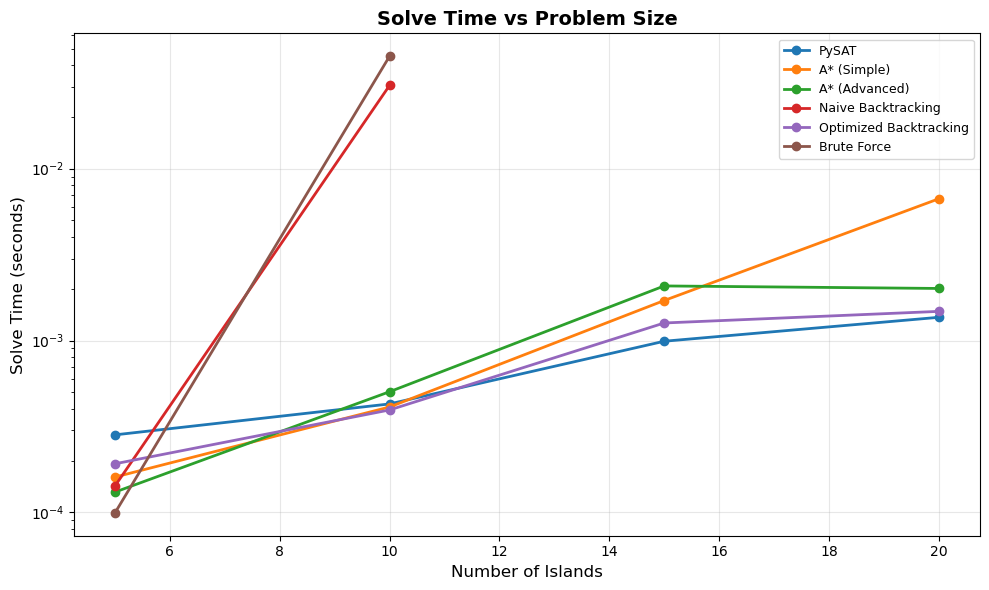

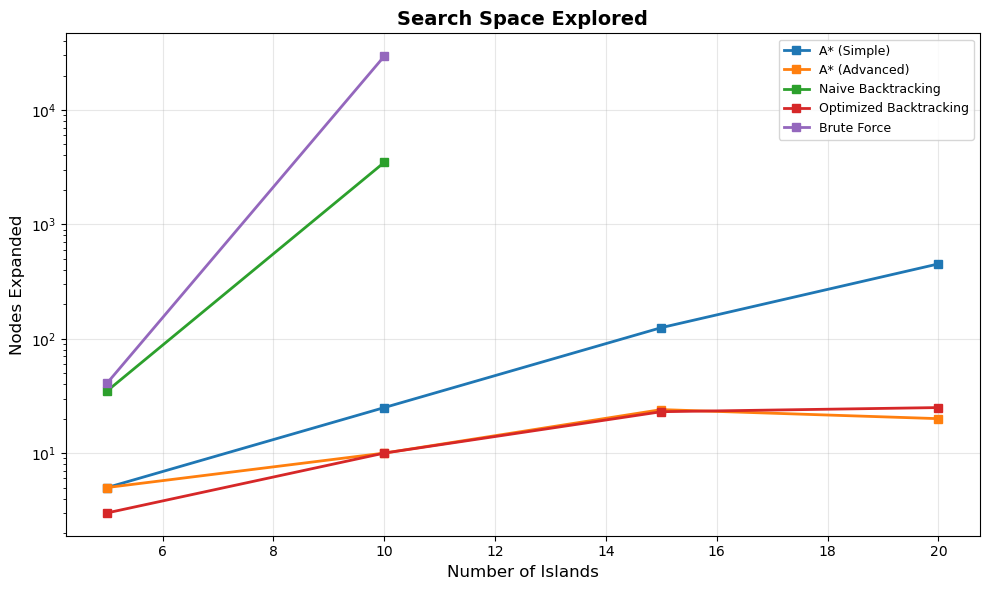

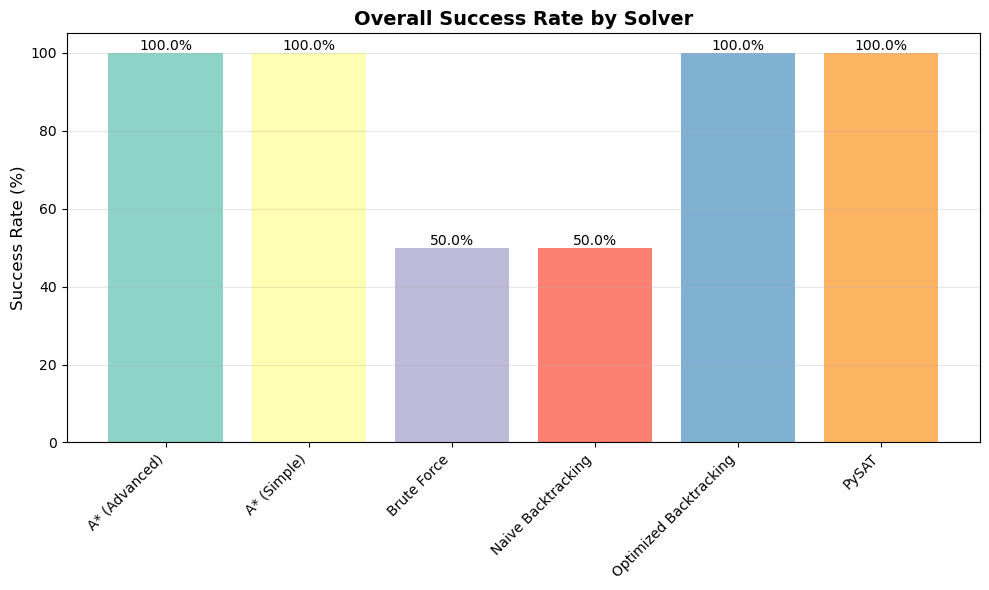

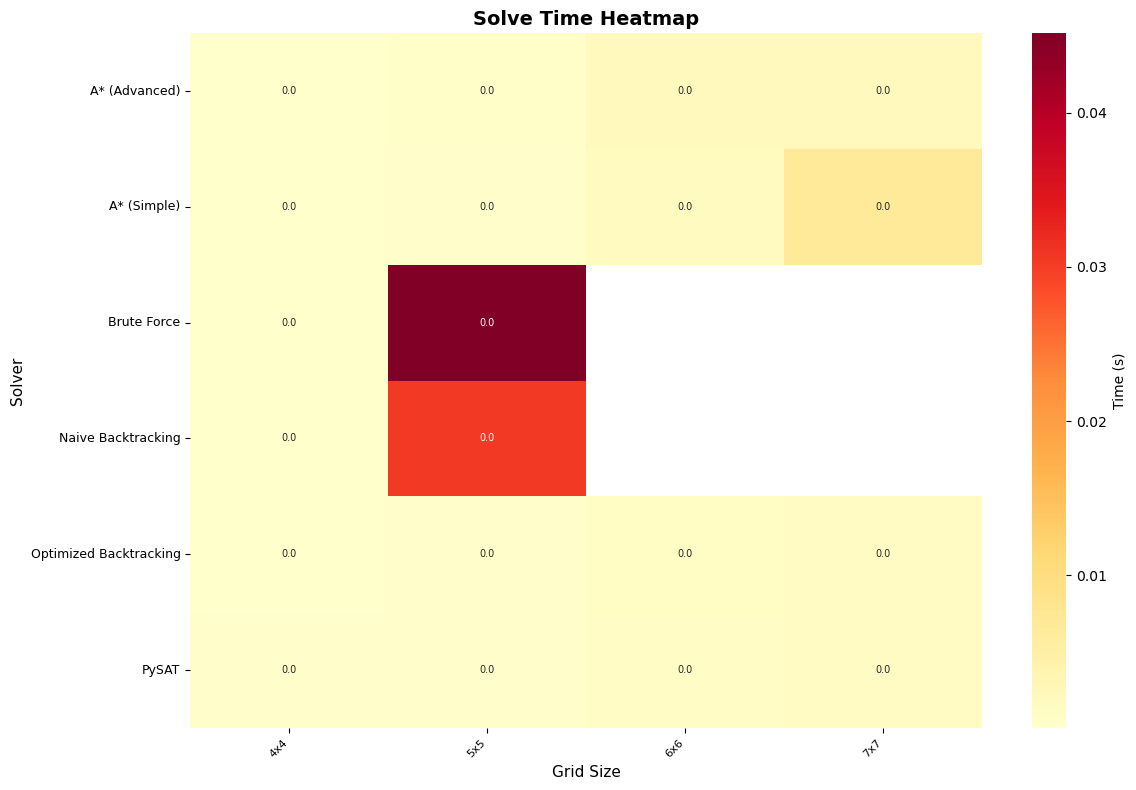

/tmp/ipykernel_5557/926073550.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful.loc[:, 'efficiency'] = successful['num_islands'] / successful['solve_time']


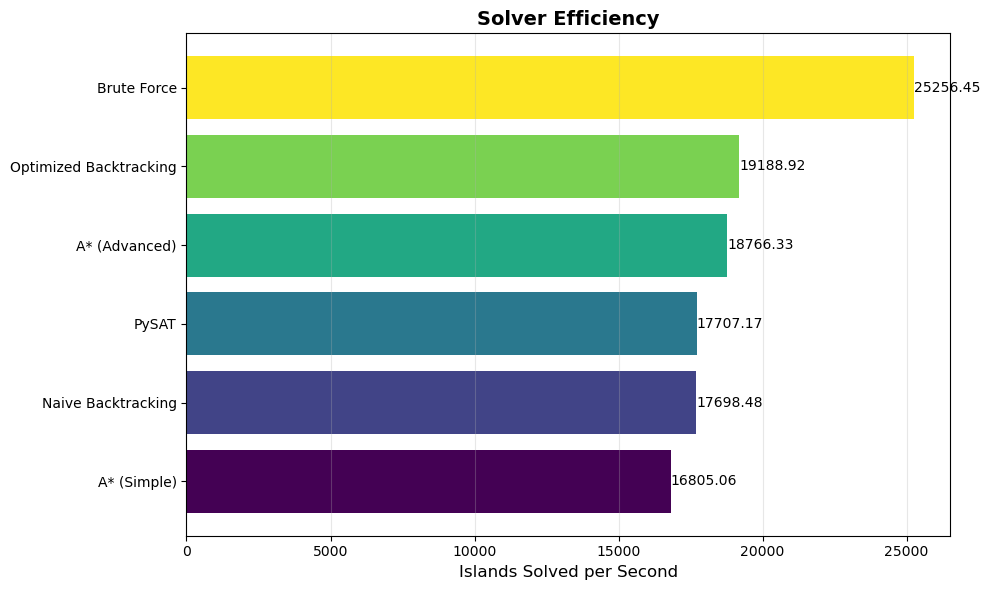

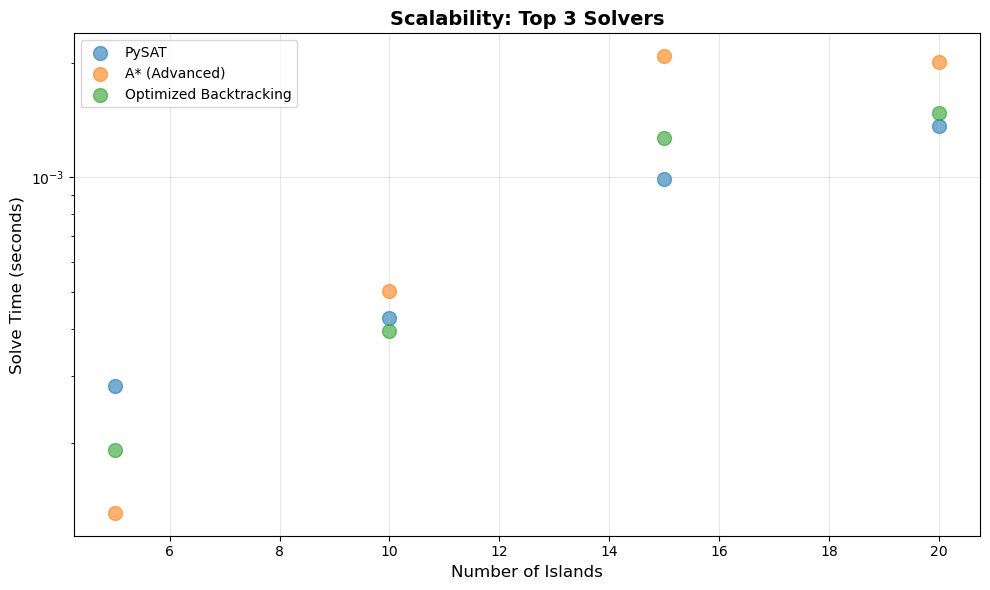

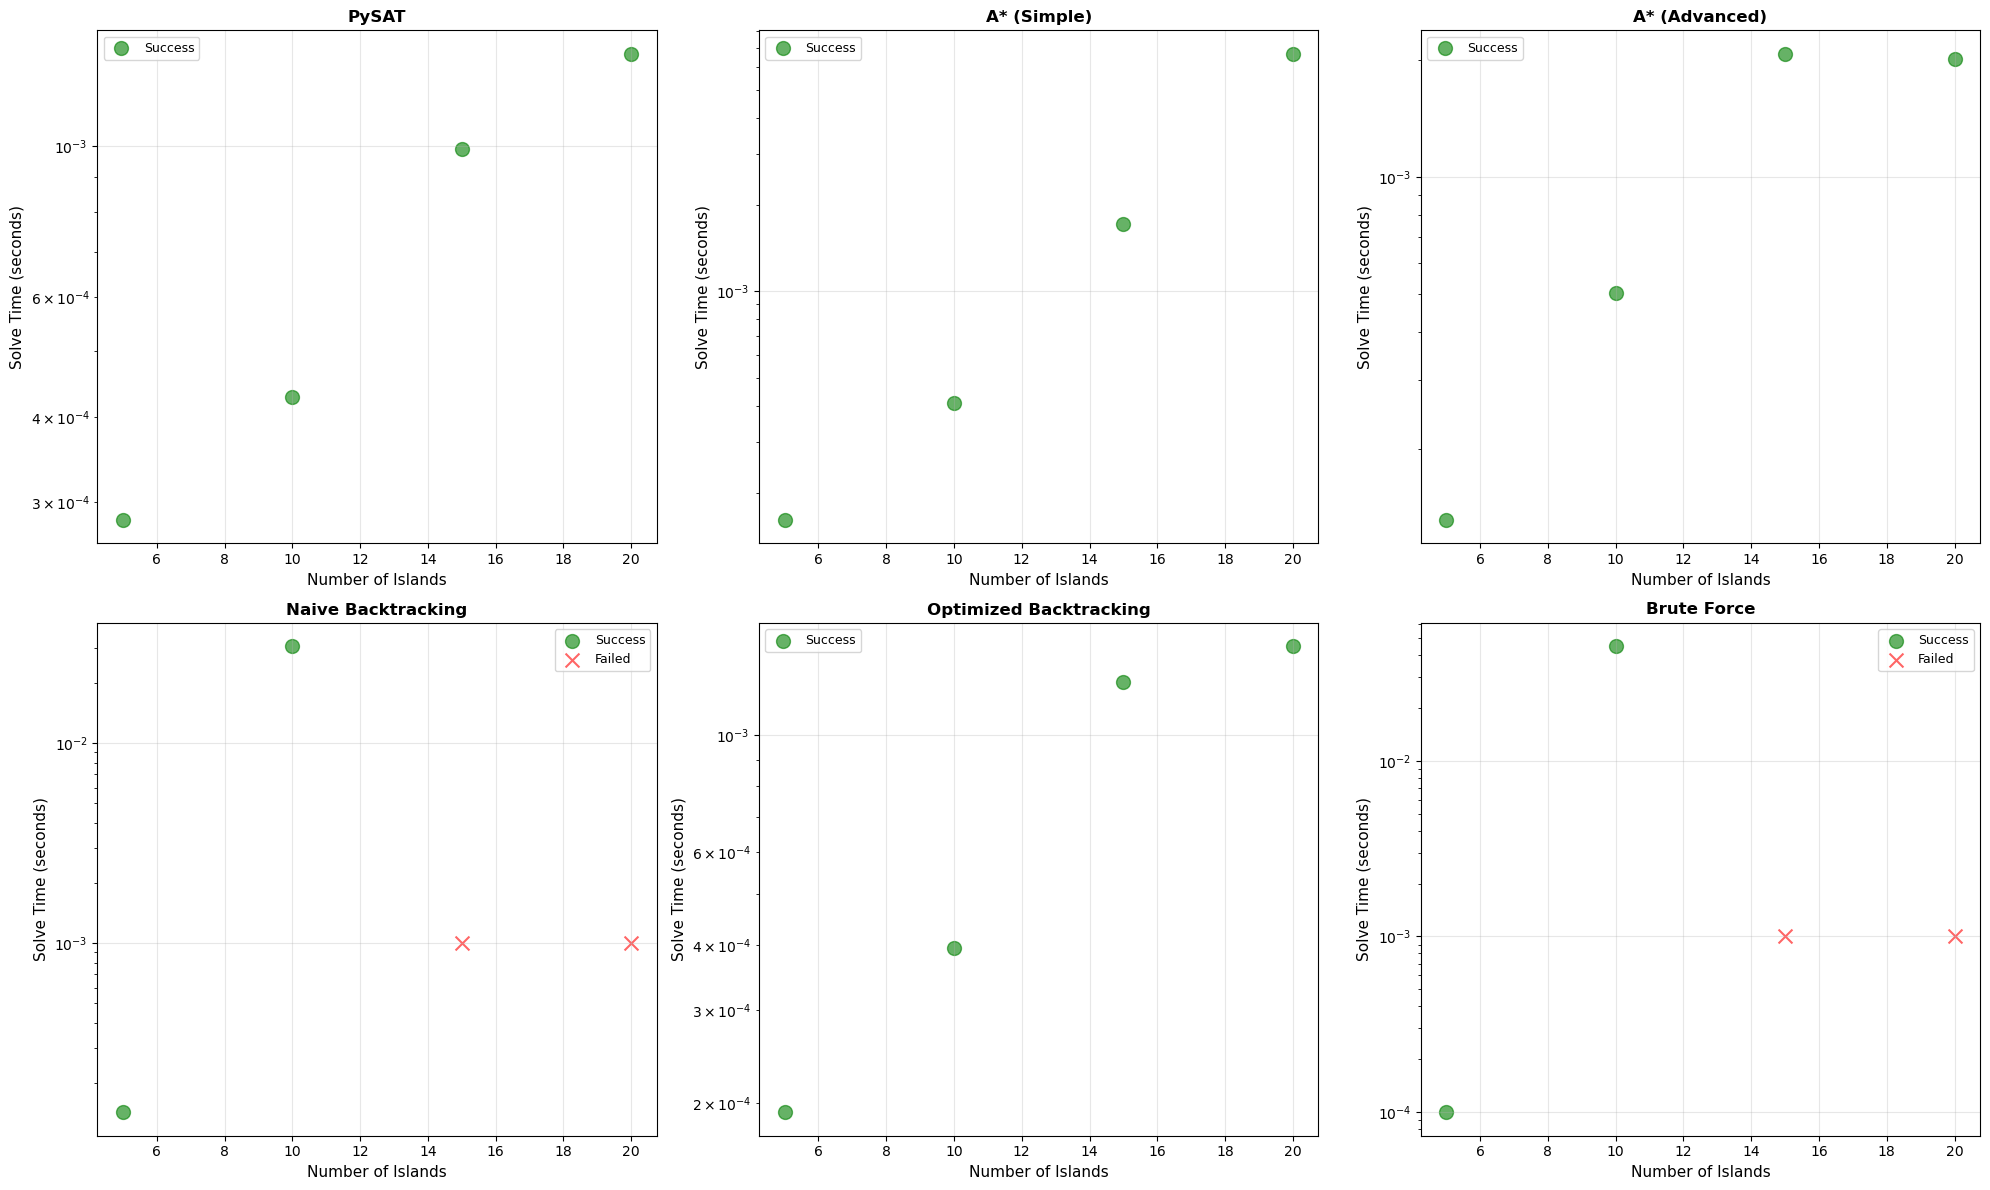


SUMMARY RESULTS

Average Solve Time (seconds):
grid_size                    4x4       5x5       6x6       7x7
solver                                                        
A* (Advanced)           0.000131  0.000504  0.002079  0.002010
A* (Simple)             0.000161  0.000411  0.001710  0.006684
Brute Force             0.000099  0.045152  0.165996  0.181054
Naive Backtracking      0.000143  0.030533  3.205450  3.864136
Optimized Backtracking  0.000192  0.000395  0.001266  0.001479
PySAT                   0.000283  0.000428  0.000991  0.001366


Average Nodes Expanded:
grid_size                4x4      5x5       6x6       7x7
solver                                                   
A* (Advanced)            5.0     10.0      24.0      20.0
A* (Simple)              5.0     25.0     125.0     451.0
Brute Force             41.0  29531.0  100001.0  100001.0
Naive Backtracking      35.0   3482.0  200015.0  200026.0
Optimized Backtracking   3.0     10.0      23.0      25.0

DETAILED ANALYS

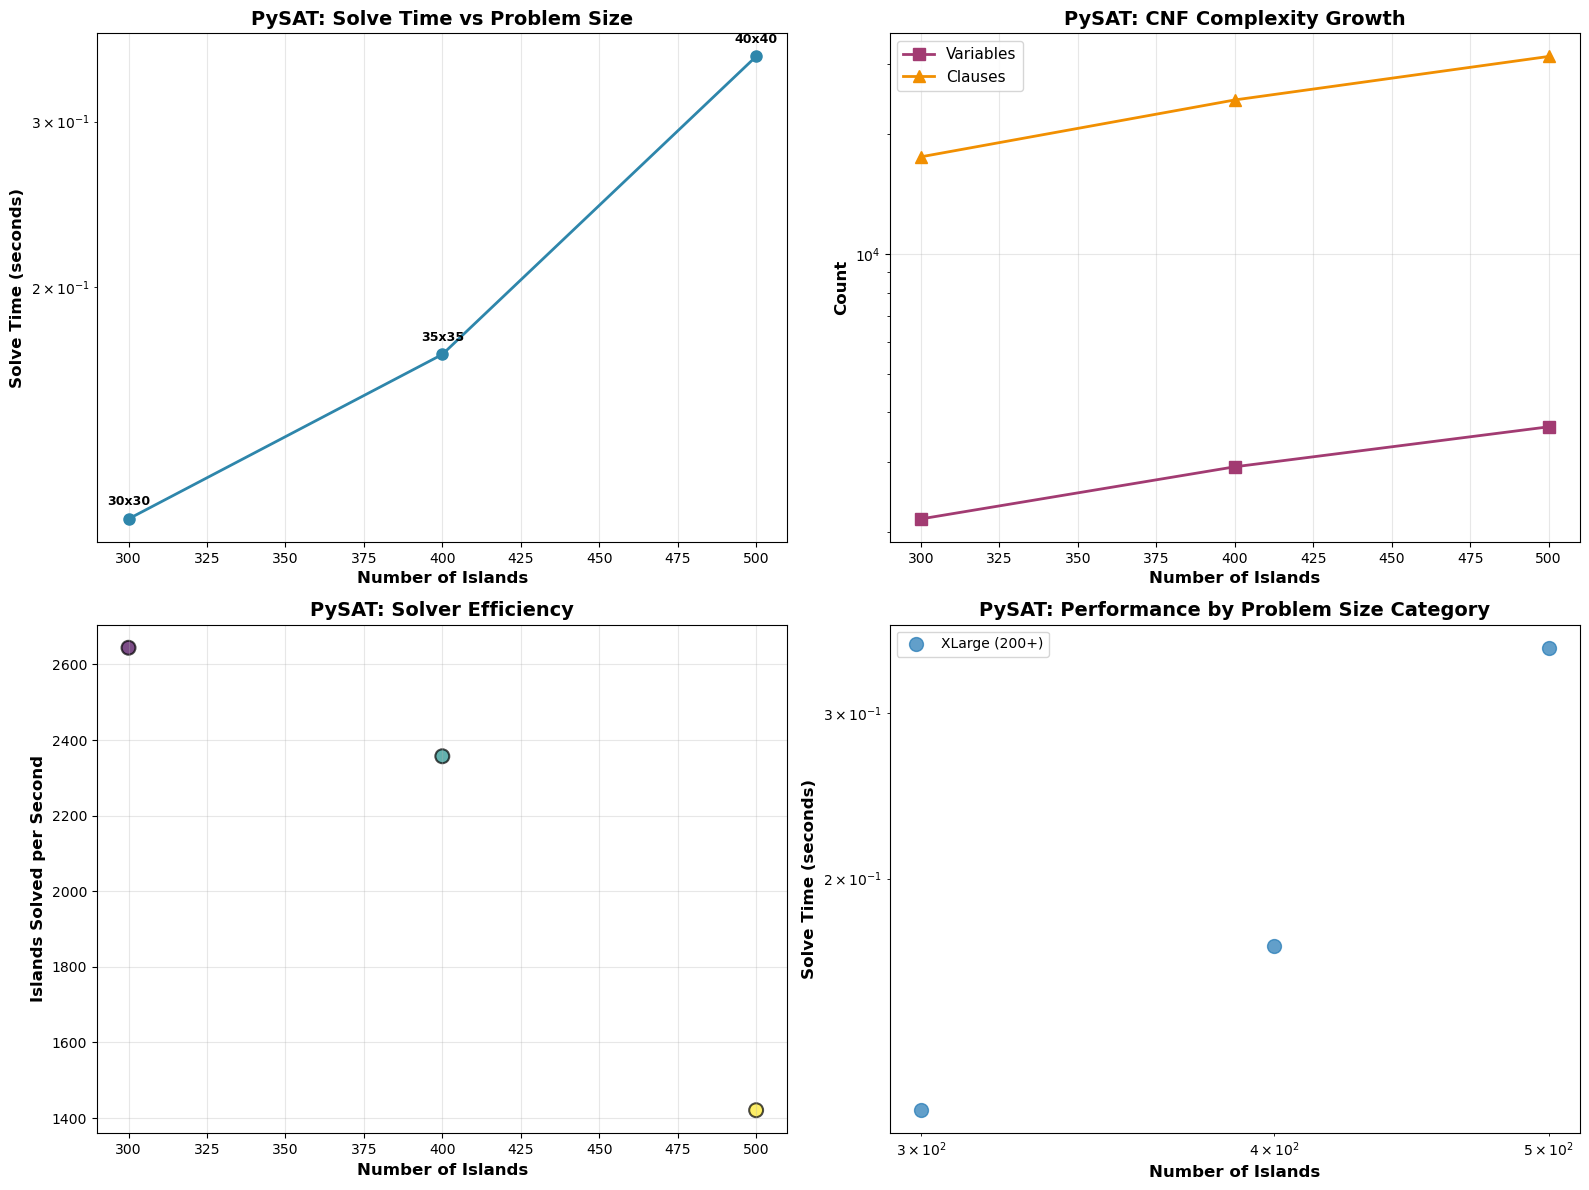


PySAT Statistical Summary:
----------------------------------------------------------------------------------------------------
Total puzzles tested: 3
Successful solves: 3
Success rate: 100.0%

Smallest puzzle: 300 islands
Largest puzzle: 500 islands

Fastest solve: 0.1135s (30x30)
Slowest solve: 0.3519s (40x40)
Average solve time: 0.2117s

Max variables: 3,680 (40x40)
Max clauses: 31,349 (40x40)

SAMPLE SOLUTION VISUALIZATION
Visualization error: [Errno 2] No such file or directory: 'input-07.txt'


In [36]:
coordinator = ExperimentCoordinator()

# Phase 1 & 2
results_standard = coordinator.run_phase1()
results_xlarge = coordinator.run_phase2()

# Save & Analyze
results_combined = coordinator.save_results(results_standard, results_xlarge)
coordinator.analyze_standard_results(results_standard)
coordinator.analyze_pysat_scalability(results_xlarge)
coordinator.visualize_sample_solution()